In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.cm import ScalarMappable
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize,rgb2hex
from matplotlib.patches import Polygon

%matplotlib inline

In [2]:
df = pd.read_csv('SHR76_16.csv')
df['State'] = df.State.apply(lambda x: x.replace('Rhodes','Rhode')) # fix a typo for basemap compatibility
df.head()

,ID,CNTYFIPS,Ori,State,Agency,Agentype,Source,Solved,Year,StateName,...,OffEthnic,Weapon,Relationship,Circumstance,Subcircum,VicCount,OffCount,FileDate,fstate,MSA
0,197601001AKASP00,"Juneau, AK",AKASP00,Alaska,State Troopers,Primary state LE,FBI,Yes,1976,ALASKA,...,Unknown or not reported,Knife or cutting instrument,Husband,Other arguments,NaN,0,0,30180,Alaska,Rural Alaska
1,197601001AL00102,"Jefferson, AL",AL00102,Alabama,Birmingham,Municipal police,FBI,Yes,1976,ALA,...,Unknown or not reported,Shotgun,Acquaintance,Felon killed by private citizen,Felon killed in commission of a crime,0,0,30180,Alabama,"Birmingham-Hoover, AL"
2,197601001AL00104,"Jefferson, AL",AL00104,Alabama,Fairfield,Municipal police,FBI,Yes,1976,ALA,...,Unknown or not reported,Shotgun,Wife,Other,NaN,0,0,30180,Alabama,"Birmingham-Hoover, AL"
3,197601001AL00106,"Jefferson, AL",AL00106,Alabama,Leeds,Municipal police,FBI,Yes,1976,ALA,...,Unknown or not reported,Knife or cutting instrument,Brother,Other arguments,NaN,0,0,30180,Alabama,"Birmingham-Hoover, AL"
4,197601001AL00201,"Mobile, AL",AL00201,Alabama,Mobile,Municipal police,FBI,Yes,1976,ALA,...,Unknown or not reported,Strangulation - hanging,Acquaintance,Circumstances undetermined,NaN,0,0,30180,Alabama,"Mobile, AL"


In [3]:
# group and pivot the data for plotting
grp = df[['ID','State','Solved']].groupby(['State','Solved'],as_index=False).count()
pvt = grp.pivot(index='State',columns='Solved',values='ID')
pvt['Total Murders'] = pvt.sum(axis=1)
pvt['UnSolved Rate'] = pvt['No'] / pvt['Total Murders']
pvt.head()

Solved,No,Yes,Total Murders,UnSolved Rate
State,,,,
Alabama,3350,12337,15687,0.213553
Alaska,362,1590,1952,0.185451
Arizona,4066,10418,14484,0.280724
Arkansas,1212,6884,8096,0.149704
California,41459,73161,114620,0.361708


In [4]:
# put the data into a dictionary for plotting
unsolved_rate_dict = pvt['UnSolved Rate'].to_dict()

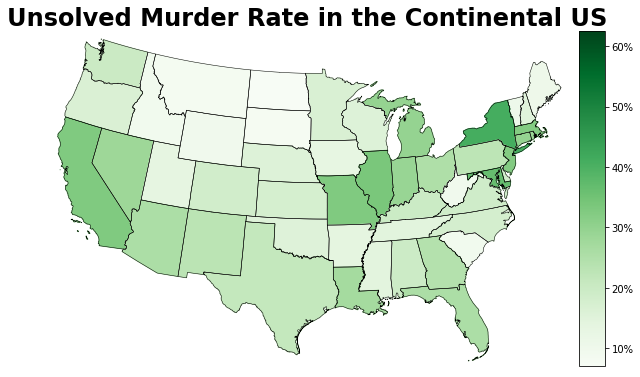

In [5]:
# https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
# the above stackoverflow question made this chart possible
fig, ax = plt.subplots(figsize=(10,7))

for pos in ax.spines:
    ax.spines[pos].set_visible(False)

m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95,ax=ax)
shp_info = m.readshapefile('st99_d00','states',drawbounds=True)

colors={}
statenames=[]
cmap = plt.cm.Greens # use 'hot' colormap
vmin = pvt['UnSolved Rate'].min(); vmax = pvt['UnSolved Rate'].max() # set range.
norm = Normalize(vmin=vmin, vmax=vmax)
mapper = ScalarMappable(norm=norm, cmap=cmap)
for shapedict in m.states_info:
    statename = shapedict['NAME']
    # skip DC and Puerto Rico.
    if statename not in ['District of Columbia','Puerto Rico']:
#         rate = unsolved_dict[statename]
        rate = unsolved_rate_dict[statename]
        # calling colormap with value between 0 and 1 returns
        # rgba value.
#         colors[statename] = cmap(rate)[:3]
        colors[statename] = cmap((rate - vmin)/vmax)[:3]
#         colors[statename] = cmap(np.sqrt((rate-vmin)/vmax))[:3]

    statenames.append(statename)
# cycle through state names, color each one.
for nshape,seg in enumerate(m.states):
    # skip DC and Puerto Rico.
    if statenames[nshape] not in ['District of Columbia','Puerto Rico']:
        color = rgb2hex(colors[statenames[nshape]]) 
        poly = Polygon(seg,facecolor=color,edgecolor=color)
        ax.add_patch(poly)
mapper.set_array([])
cbar = m.colorbar(mapper,ax=ax,format=mpl.ticker.PercentFormatter(xmax=1))
ax.set_title('Unsolved Murder Rate in the Continental US',fontsize=24,fontweight='bold')
plt.show()